# Final Presentation

## Pipeline

<img style="float: right;" src="https://raw.githubusercontent.com/Mt-Kunlun/MarkdownPhotos/master/Res/pipeline.png" width="100%">

## Preparation

In [17]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import nltk
from nltk.corpus import stopwords
from string import punctuation
from gensim import corpora
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.corpus import reuters
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

E:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv('C:\\Users\\51645\\Desktop\\fake_news\\fake_or_real_news.csv')
df1 = pd.read_csv('C:\\Users\\51645\\Desktop\\fake_news\\fake.csv')
#fake news dataset from https://www.kaggle.com/burakhmmtgl/exploratory-analysis/data
df2 = pd.read_csv('C:\\Users\\51645\\Desktop\\fake_news\\Real.csv')
#real news dataset from https://www.kaggle.com/snapcrack/all-the-news/data
df.head()

,Unnamed: 0,title,text,label,title_vectors
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,[ 1.1533764e-02 4.2144405e-03 1.9692603e-02 ...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,[ 0.11267698 0.02518966 -0.00212591 0.021095...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,[ 0.04253004 0.04300297 0.01848392 0.048672...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,[ 0.10801624 0.11583211 0.02874823 0.061732...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,[ 1.69016439e-02 7.13498285e-03 -7.81233795e-...


## Clean Data

In [3]:
def clean_text(tokenized_list, sw):
    new_list = []
    nodes = [',', '*', '"', '.', '\'', '“', '”', '’', '‘', '，']
    for doc in tokenized_list:
        new_list.append([token.lower() for token in doc if token.lower() not in sw and token.lower() not in nodes])
    return new_list

texts = df.text

#create mapping for string translate method
mapping_table = {ord(char): u' ' for char in punctuation}

tokenized = [nltk.word_tokenize(review.translate(mapping_table)) for review in texts]

# Remove punctuations and stopwords, and lower-case text
sw = stopwords.words('english')
cleaned = clean_text(tokenized, sw)

## Get TF-IDF for each text

In [4]:
vectorizer = TfidfVectorizer()
Tf_fit = []
# for each text, turn the text into list of words
for article in cleaned:
    str = ''
    for i in article:
        str += i
        str += ' '
    Tf_fit.append(str)

In [5]:
vectorizer.fit(Tf_fit)
tfidf_matrix = vectorizer.transform(Tf_fit).toarray()
print(tfidf_matrix)
print(len(tfidf_matrix[0]))

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.01034503  0.         ...,  0.          0.          0.        ]
 [ 0.          0.01270221  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
67558


## PCA Decomposition for the TF-IDF matrix

In [6]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA(n_components = 500)
pca.fit(tfidf_matrix)
X_tf = pca.transform(tfidf_matrix)
X_tf.tofile("tfidf_matrix_500.bin")

'\npca.fit(tfidf_matrix)\nX_tf = pca.transform(tfidf_matrix)\nX_tf.tofile("tfidf_matrix_500.bin")\n\n'

## Prepare data for the classification

In [8]:
X_tf500 = np.fromfile("C:\\Users\\51645\\Desktop\\fake_news\\tfidf_matrix_6335_500.bin")
X_tf500.shape = 6335, 500
X_tf500

array([[ 0.08367505,  0.41453202, -0.1365418 , ..., -0.00349437,
         0.00598387,  0.00284075],
       [ 0.10516965, -0.1018543 , -0.07499441, ..., -0.01728784,
        -0.01019226, -0.01649624],
       [-0.08337797, -0.02132731,  0.09598185, ...,  0.00864918,
         0.01190413,  0.03372494],
       ..., 
       [ 0.09876725, -0.04909523,  0.00227706, ..., -0.00569073,
        -0.00123435, -0.0120559 ],
       [-0.07174388, -0.02140137,  0.10833566, ..., -0.010136  ,
        -0.02771981, -0.01208612],
       [ 0.31185574, -0.21482338, -0.04275505, ..., -0.00265663,
        -0.00849138, -0.00640356]])

In [11]:
X_ = np.fromfile('C:\\Users\\51645\\Desktop\\fake_news\\doc2vec_title300_text300_kunlun.bin')
X_.shape = 6335, 600
X_ = np.hstack((X_, X_tf500))
y_ = np.fromfile('C:\\Users\\51645\\Desktop\\fake_news\\test_y_33.bin', dtype = int)

In [12]:
seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = test_size, random_state = seed)

## Best XGBoost Result

### Notice:
For convience of looking, we omit the hyper tunning process here, which take lots of places.

### Input: 300 doc2vec for text, 300 word2vec for title, 500 TF-IDF vector
### Result: F1: 0.947

In [28]:
XGmodel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bytree=1, gamma=0, learning_rate=0.06, max_delta_step=0,
           max_depth=3, min_child_weight=1, missing=None, n_estimators=1400,
           n_jobs=2, nthread=None, objective='binary:logistic', random_state=0,
           reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
           silent=True, subsample=1)

XGmodel.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.06, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1400,
       n_jobs=2, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

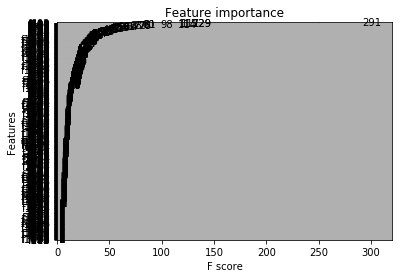

In [27]:
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(XGmodel)
pyplot.figure(figsize = (1200, 1200))
pyplot.show()

In [29]:
from sklearn.metrics import classification_report

y_pred1 = XGmodel.predict(X_test)
target_names = ['Fake', 'Real']
print(classification_report(y_test, y_pred1, target_names=target_names))
f1 = metrics.f1_score(y_test, y_pred1)
print('F1 score:', f1)

             precision    recall  f1-score   support

       Fake       0.94      0.96      0.95      1071
       Real       0.95      0.94      0.95      1020

avg / total       0.95      0.95      0.95      2091

F1 score: 0.947160493827


## Best Random Forrests Model

In [43]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                             min_impurity_split=None, bootstrap=True,
                             oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
rdf = clf.fit(X_train, y_train)
y_pred2 = clf.predict(X_test)
rdf.score(X_test, y_test)

print(classification_report(y_test, y_pred2, target_names = target_names))
f1 = metrics.f1_score(y_test, y_pred2)
print('F1 score:', f1)

              precision    recall  f1-score   support

Not Admitted       0.80      0.94      0.86      1071
    Admitted       0.92      0.76      0.83      1020

 avg / total       0.86      0.85      0.85      2091

F1 score: 0.829924650161


## Best MLP Model

In [42]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
                    learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
MLP.fit(X_train, y_train)

y_pred3 = MLP.predict(X_test)
print(classification_report(y_test, y_pred3, target_names = target_names))
f1 = metrics.f1_score(y_test, y_pred3)
print('F1 score:', f1)

              precision    recall  f1-score   support

Not Admitted       0.93      0.92      0.93      1071
    Admitted       0.92      0.93      0.92      1020

 avg / total       0.92      0.92      0.92      2091

F1 score: 0.922776148583


## Best SVM Model

In [44]:
from sklearn import svm
Svm = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False,
              tol=0.001, cache_size=200,
              class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None)
Svm.fit(X_train, y_train)

y_pred4 = clf.predict(X_test)
Svm.score(X_test, y_test)

print(classification_report(y_test, y_pred4, target_names = target_names))
f1 = metrics.f1_score(y_test, y_pred4)
print('F1 score:', f1)

              precision    recall  f1-score   support

Not Admitted       0.80      0.94      0.86      1071
    Admitted       0.92      0.76      0.83      1020

 avg / total       0.86      0.85      0.85      2091

F1 score: 0.829924650161


## Best Logistic Regression Model

In [45]:
from sklearn.linear_model import LogisticRegression

Logistic_model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None,
                                    random_state=None,
                                    solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
Logistic_model = model.fit(X_train, y_train)

y_pred5 = model.predict(X_test)

Logistic_model.score(X_test, y_test)

from sklearn.metrics import classification_report

target_names = ['Not Admitted', 'Admitted']

print(classification_report(y_test, y_pred5, target_names=target_names))
f1 = metrics.f1_score(y_test, y_pred5)
print('F1 score:', f1)

              precision    recall  f1-score   support

Not Admitted       0.90      0.93      0.92      1071
    Admitted       0.92      0.90      0.91      1020

 avg / total       0.91      0.91      0.91      2091

F1 score: 0.909000497265


# Vote Model

In [47]:
def vote_func_5(X_test):
    
    y_pred1 = XGmodel.predict(X_test)
    y_pred2 = rdf.predict(X_test)
    y_pred3 = Svm.predict(X_test)
    y_pred4 = Logistic_model.predict(X_test)
    y_pred5 = MLP.predict(X_test)
    
    y_pred = []
    for i in range(len(y_pred1)):
        if y_pred1[i] + y_pred2[i] + y_pred3[i] + y_pred4[i] + y_pred5[i] >= 3:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

In [61]:
def vote_func_3(X_test):
    
    y_pred1 = XGmodel.predict(X_test)
    y_pred2 = Logistic_model.predict(X_test)
    y_pred3 = MLP.predict(X_test)
    
    y_pred = []
    for i in range(len(y_pred1)):
        if y_pred1[i] + y_pred2[i] + y_pred3[i] >= 2:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

In [63]:
def vote_func_2(X_test):
    
    y_pred1 = XGmodel.predict(X_test)
    y_pred2 = MLP.predict(X_test)
    
    y_pred = []
    for i in range(len(y_pred1)):
        if y_pred1[i] + y_pred2[i] >= 1:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

### Best five models

In [48]:
y_pred = vote_func_5(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))
f1 = metrics.f1_score(y_test, y_pred)
print('F1 score:', f1)

              precision    recall  f1-score   support

Not Admitted       0.91      0.95      0.93      1071
    Admitted       0.94      0.90      0.92      1020

 avg / total       0.92      0.92      0.92      2091

F1 score: 0.918213748118


### Best three models

In [62]:
y_pred = vote_func_3(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))
f1 = metrics.f1_score(y_test, y_pred)
print('F1 score:', f1)

              precision    recall  f1-score   support

Not Admitted       0.93      0.94      0.94      1071
    Admitted       0.94      0.92      0.93      1020

 avg / total       0.93      0.93      0.93      2091

F1 score: 0.931683168317


### Best two models

In [64]:
y_pred = vote_func_2(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))
f1 = metrics.f1_score(y_test, y_pred)
print('F1 score:', f1)

              precision    recall  f1-score   support

Not Admitted       0.96      0.91      0.94      1071
    Admitted       0.91      0.96      0.94      1020

 avg / total       0.94      0.94      0.94      2091

F1 score: 0.935622317597


# Conclusion

(1) The best size for TF-IDF is around 500  
(2) The best F1-rate we get right now is around 0.95  
(3) The Vote method didn't help as much as we thought it would be  
(4) The best model we use is still XGBoost  